In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import math
import scipy.stats as sts
import scipy.optimize as opt
import scipy.integrate as integrate
import numpy.linalg as linalg

In [126]:
#First I try to define a function that feeds in data and returns a histogram. Pretty different from R. 
def histogram (data):
    w=(100/len(data))*np.ones(len(data))
    count, bins, patches = plt.hist(data, 30, weights=w)
    plt.title('Salary of Graduates', fontsize=30)
    plt.xlabel("Salary")
    plt.ylabel('Percentages')
    

    
#Now, I try to plot the histogram with a pdf below
def plots_pdf (data, mean, sd, name, mean2=None, sd2=None, mult=False):
    count, bins, patches=plt.hist(data, 30, normed=True)
    plt.title("Salary of Graduates and PDF Function Graphed", fontsize=30)
    plt.xlabel("Salary")
    plt.ylabel("Probability")
    
    mean_rounded=round(mean,5)
    sd_rounded=round(sd, 5)
    breaks=np.linspace(0,150000,500)
    plt.plot(breaks, lognormalpdf(breaks, mean, sd),
             linewidth=4, color="r", label=('mean:',mean_rounded, 'sd:', sd_rounded))
    plt.legend(loc='upper left')
    
    if mult:
        mean2_rounded=round(mean2, 5)
        sd2_rounded=round(sd2,5)
        breaks=np.linspace(0.000001, 150000, 500)
        plt.plot(breaks, lognormalpdf(breaks, mean2, sd2),
                linewidth=2, color='r', label=("mean:",mean2_rounded, "sd:", sd2_rounded))
        plt.legend(loc="upper left")
        
def lognormalpdf(x, mean, sd):
    pdf=(1/(x*sd*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mean)**2/(2*sd**2)))
    return pdf

def moments_fun (xvalues):
    mean_data=xvalues.mean()
    sd_data=xvalues.std()
    
    return mean_data, sd_data

def model_moments(mean, sd):
    xfx=lambda x: x* lognormalpdf(x, mean, sd)
    (mean_model, m_m_err)=integrate.quad(xfx, 0, 150000)
    x2fx=lambda x:((x-mean_model)**2)*lognormalpdf(x, mean, sd)
    (var_model, v_m_err)=integrate.quad(x2fx, 0, 150000)
    std_model=np.sqrt(var_model)
    return mean_model, std_model

def error_vector(xvalues, mean, sd, simple):
    mean_data, sd_data=moments_fun(xvalues)
    moments=np.array([[mean_data], [sd_data]])
    mean_model, sd_model=model_moments(mean, sd)
    model_moments_return=np.array([[mean_model], [sd_model]])
    if simple:
        error_vector=model_moments_return- model_moments
    else:
            error_vector=(model_moments_return-moments)/moments
            return error_vector
        
def criterion (params, *args):
    mean, sd=params
    xvals, cutoff, W=args
    err=error_vector(xvals, mean, sd, simple=False)
    critical_value=np.dot(np.dot(err.T, W), err)
    return critical_value



None


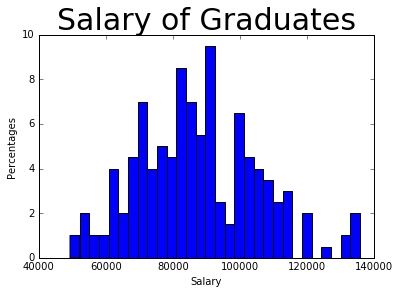

In [127]:
#Problem 1(a)
incomes= np.loadtxt('incomes.txt')
print(histogram(incomes))

Value of GMM criterion: 4.79000096933e-16
Mean of points: 87588.9307685 SD of points 18035.9068271
Mean of model: 87588.93135953903 SD of model 18035.9064516


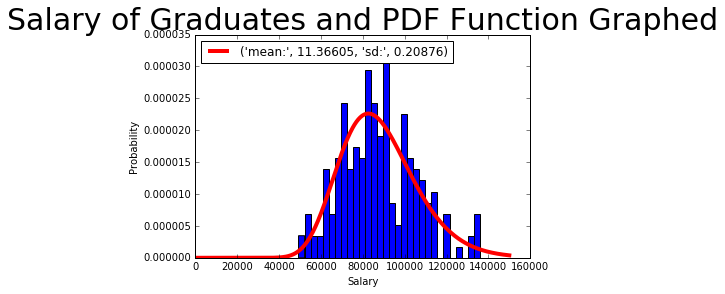

In [128]:
#Part1B
init_mean=11.3 #borrowed from results of the last pset
init_sd=0.2
init_parameters=np.array([init_mean, init_sd])
weighting_m=np.eye(2)

args=(incomes, 150000, weighting_m)
result=opt.minimize(criterion, init_parameters, args=(args), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

GMM_mean, GMM_sd=result.x

mean_data, sd_data=moments_fun(incomes)
mean_model, sd_model=model_moments(GMM_mean, GMM_sd)
errors=error_vector(incomes, GMM_mean, GMM_sd, False).reshape(2,)
GMM_vals=np.array([GMM_mean, GMM_sd])
GMM_value=result.fun[0][0]
print("Value of GMM criterion:", GMM_value)
print("Mean of points:", mean_data, "SD of points", sd_data)
print("Mean of model:", mean_model, "SD of model", sd_model)
plots_pdf(incomes, GMM_mean, GMM_sd, "Question 1b")

Mean: 11.3660508418 Sigma: 0.208759118669
Value of GMM Criterion Function: 1.0958591862


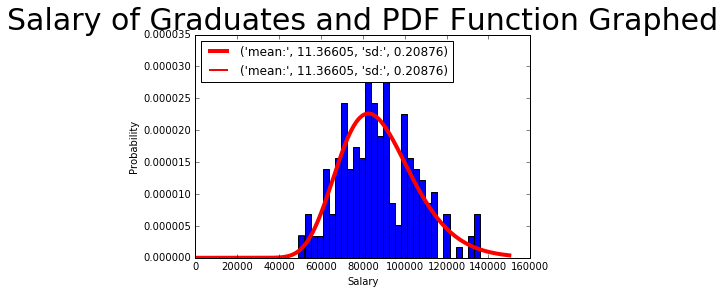

In [129]:
errors=error_vector(incomes, GMM_mean, GMM_sd, False)
VCV2=np.dot(errors, errors.T)/incomes.shape[0]
weighting_matrix2=linalg.pinv(VCV2)
initial_parameters=np.array([GMM_mean, GMM_sd])
args=(incomes, 150000, weighting_matrix2)
results=opt.minimize(criterion, initial_parameters, args=(args), method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
GMM_mean_two, GMM_SD_two=results.x

GMM_vals=np.array([GMM_mean_two, GMM_SD_two])
GMM_value=criterion(GMM_vals, *args)[0][0]
print("Mean:", GMM_mean_two, "Sigma:", GMM_SD_two)
print("Value of GMM Criterion Function:", GMM_value)
plots_pdf(incomes, GMM_mean, GMM_sd, "Question 1c", GMM_mean_two, GMM_SD_two, True)

In [133]:
#Problem 1d)
def data_moments_two(xvals):
    bpct_1_dat=xvals[xvals<75000].shape[0]/xvals.shape[0]
    bpct_2_dat=(xvals[(xvals>=75000)&xvals<100000].shape[0]/xvals.shape[0])
    bpct_3_dat=(xvals[xvals>=100000].shape[0]/xvals.shape[0])
    return(bpct_1_dat, bpct_2_dat, bpct_3_dat)

def model_moments_two(mean, sd):
    xfx=lambda x: lognormalpdf(x, mean, sd)
    (bpct_1_mod, bp_1_err)=integrate.quad(xfx, 0, 75000)
    (bpct_2_mod, bp_2_err)=integrate.quad(xfx, 100000, np.inf)
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def err_vec_two(xvals, mean, sd):
    bpct_1_dat, bpct_2_dat, bpct_3_dat=data_moments_two(xvals)
    moments=np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    model_bpct_1, model_bpct_2, model_bpct_3=model_moments_two(mean, sd)
    moments_model_return=np.array([[model_bpct_1], [model_bpct_2], [model_bpct_3]])
    error_vector=(moments_model_return-moments)/moments

def criterion_two(params, *args):
    mean,sd=params
    xvals, W=args
    err=err_vec_two(xvals, mean, sd)
    critical=np.dot(np.dot(err.T, W), err)
    return critical

init_mean=11.33
init_sd=0.2
init_parameters=np.array([init_mean, init_sd])
weighting_matrix=np.eye(3)
args=(incomes,weighting_matrix)
results2=opt.minimize(criterion_two, init_parameters, args=(args), method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
GMM_mean_1d, GMM_sd_1d=results2.x
GMM_param=np.array([init_mean, init_sd])
GMM_value=criterion_two(GMM_param, *gmm_args)[0][0]

#couldn't get this part to work so I stopped here...

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''